In [1]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()


170508288/170498071 [==============================] - 2s 0us/step


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 32, 32, 3))
    return array


In [4]:
# Normalize and reshape the data
train_data = preprocess(x_train)
test_data = preprocess(x_test)


In [7]:
input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same", name='feats')(x)

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 feats (MaxPooling2D)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16, 16, 128)      147584    
 ranspose)                                                 

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(monitor='loss', patience=5, mode='mine')

history=autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(test_data, test_data),
    callbacks=[es]
)

Epoch 1/50
782/782 [==============================] - 13s 16ms/step - loss: 0.5656 - val_loss: 0.5570
Epoch 2/50
782/782 [==============================] - 12s 15ms/step - loss: 0.5551 - val_loss: 0.5545
Epoch 3/50
782/782 [==============================] - 12s 15ms/step - loss: 0.5532 - val_loss: 0.5535
Epoch 4/50
782/782 [==============================] - 12s 15ms/step - loss: 0.5522 - val_loss: 0.5528
Epoch 5/50
782/782 [==============================] - 11s 15ms/step - loss: 0.5517 - val_loss: 0.5536
Epoch 6/50
782/782 [==============================] - 11s 15ms/step - loss: 0.5513 - val_loss: 0.5520
Epoch 7/50
782/782 [==============================] - 11s 15ms/step - loss: 0.5510 - val_loss: 0.5515
Epoch 8/50
782/782 [==============================] - 12s 15ms/step - loss: 0.5507 - val_loss: 0.5514
Epoch 9/50
782/782 [==============================] - 12s 15ms/step - loss: 0.5505 - val_loss: 0.5513
Epoch 10/50
782/782 [==============================] - 12s 15ms/step - loss: 0.550

In [9]:
model_part = Model(
  inputs=autoencoder.input,
  outputs=autoencoder.get_layer("feats").output)

In [10]:
train_feats=model_part.predict(train_data)
test_feats=model_part.predict(test_data)

In [11]:
train_feats.shape

(50000, 8, 8, 128)

In [18]:
train_feats=np.reshape(train_feats,(len(train_feats),-1))
train_feats.shape

(50000, 8192)

In [19]:
test_feats=np.reshape(test_feats,(len(test_feats),-1))
test_feats.shape

(10000, 8192)

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42, max_iter=1000, algorithm='elkan', tol=0.000001).fit(train_feats)

preds=kmeans.predict(test_feats) # use features extracted from denseNet
preds.shape

(10000,)

In [27]:
y_test = K.utils.to_categorical(y_test)
y_test.shape

(10000, 10)

In [28]:
y1=np.argmax(y_test,axis=1)
y1.shape

(10000,)

In [29]:
np.unique(y1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
# assign predicted clusters to actual classes to get the accuracy
from collections import Counter

correct=0
mapping={}

for val in set(y1):
  inds=[i for i in range(len(y1)) if y1[i]==val] # all indices for a particular class
  p=preds[inds] # predictions made for that class
  y2=y1[inds]
  counts=dict(Counter(p))

  print("y2: ", y2[:2])
  print("counts: ", counts)
  print("----------------")

y2:  [0 0]
counts:  {3: 125, 5: 287, 9: 215, 8: 73, 4: 33, 7: 65, 0: 37, 6: 60, 2: 23, 1: 82}
----------------
y2:  [1 1]
counts:  {4: 113, 3: 102, 8: 199, 0: 87, 2: 61, 1: 214, 9: 60, 6: 94, 7: 49, 5: 21}
----------------
y2:  [2 2]
counts:  {8: 46, 1: 66, 4: 134, 5: 72, 7: 206, 0: 242, 9: 79, 6: 54, 2: 63, 3: 38}
----------------
y2:  [3 3]
counts:  {1: 122, 7: 149, 0: 165, 8: 71, 2: 140, 4: 144, 6: 99, 5: 16, 9: 69, 3: 25}
----------------
y2:  [4 4]
counts:  {4: 149, 2: 159, 7: 175, 0: 308, 5: 25, 8: 55, 6: 46, 9: 19, 3: 21, 1: 43}
----------------
y2:  [5 5]
counts:  {1: 176, 2: 164, 7: 215, 6: 82, 8: 43, 0: 139, 9: 45, 4: 96, 3: 26, 5: 14}
----------------
y2:  [6 6]
counts:  {2: 78, 0: 306, 4: 226, 7: 120, 8: 33, 9: 54, 6: 93, 1: 80, 3: 7, 5: 3}
----------------
y2:  [7 7]
counts:  {4: 68, 6: 156, 8: 149, 0: 169, 2: 133, 7: 130, 9: 42, 3: 55, 1: 84, 5: 14}
----------------
y2:  [8 8]
counts:  {3: 260, 8: 195, 1: 128, 9: 34, 5: 205, 6: 25, 7: 60, 2: 44, 4: 30, 0: 19}
------------

In [31]:
#autoencoder
mapping={
    0:5,
    1:1,
    2:0,
    3:7,
    4:0,
    5:7,
    6:0,
    7:6,
    8:3,
    9:8
}
correct=0
for val in set(y1):
  inds=[i for i in range(len(y1)) if y1[i]==val] # all indices
  p=preds[inds]
  y2=y1[inds]
  counts=dict(Counter(p))
  correct+=counts[mapping[y2[0]]]
print("accuracy: ", correct*100/len(y1))

accuracy:  24.58


In [32]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(test_feats)
X_embedded.shape

(10000, 2)

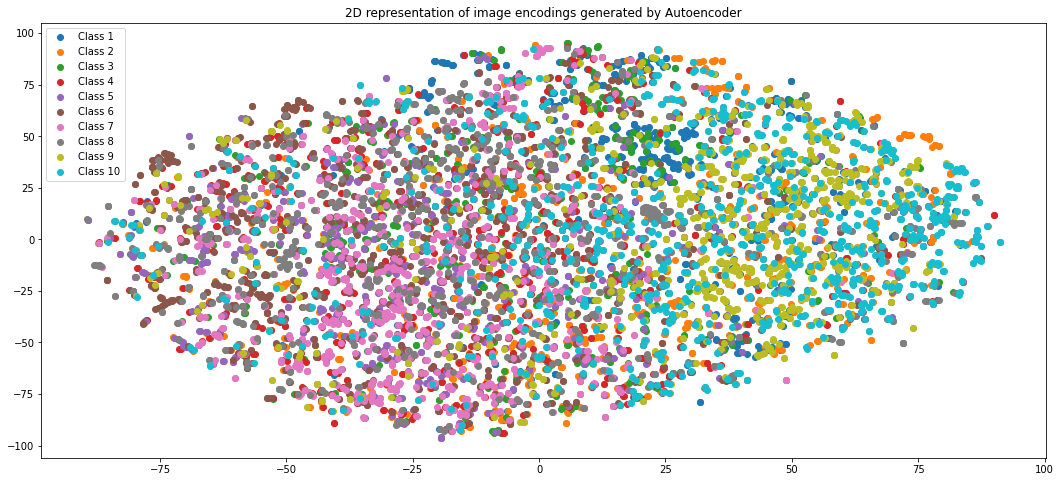

In [33]:
plt.figure(figsize=(18,8))
i=1
for val in set(y1):
  inds=[j for j in range(len(y1)) if y1[j]==val] # all indices
  X1=X_embedded[inds]
  plt.scatter(X1[:,0],X1[:,1],label="Class "+str(i))
  i+=1
plt.legend()
plt.title("2D representation of image encodings generated by Autoencoder")
plt.show()